# Portfolio optimization

This notebook presents reinforcement learning for chaotic mean variance optimization as defined in the article from Vadori and al.  [5].

## Imports

In [1]:
import sys
import numpy as np
import numpy.random as npr
import torch
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from tqdm.notebook import trange
%matplotlib inline

torch.set_default_dtype(torch.float)

In [2]:
# To reload the module
%load_ext autoreload
%autoreload 2
sys.path.append('../')
from portfolio.portfolio_class import Portfolio
from portfolio.portfolio_methods import CMV_actor_critic, CMV_actor_critic_dis
from src.utils import fix_seeds
from src.network import Net, PolicyNetPortfolio

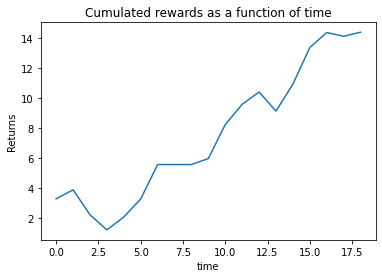

In [4]:
# Random episode

portfolio = Portfolio()
returns = []
portfolio.reset(0)
for i in range(portfolio.T-1):
    idx_action = npr.randint(low=0,high=portfolio.num_actions) #random
    state,reward= portfolio.act(idx_action)
    returns.append(portfolio.total_reward)
plt.plot(returns)
plt.title("Cumulated rewards as a function of time")
plt.xlabel("time")
plt.ylabel("Returns")
plt.show()

## Optimal strategy as a function of penalization

We start by training our model with respect to chaotic mean-variance risk measure with different penalizations. Then, we plot the investment proportion as a function of penalization for every state according to our trained policies. Comparing with the original paper ensures the validity of the implementation

In [ ]:
p_RF_LV = []
p_R_LV = []
p_NI_LV = []

p_RF_MV = []
p_R_MV = []
p_NI_MV = []

p_RF_HV = []
p_R_HV = []
p_NI_HV = []

tab_pen = np.linspace(0,1.5)

for pen in tab_pen:
    fix_seeds()
    policy_model = PolicyNetPortfolio(1, portfolio.num_actions)
    portfolio = Portfolio()
    cmv = CMV_actor_critic(policy_model, portfolio, n_epochs=2000, lambd=pen, lr=0.002, alpha=0.2)
    RF,R = portfolio.actions[np.argmax(policy_model.forward(torch.tensor(0, dtype=torch.float).unsqueeze(0)).detach())]
    print(RF,R)
    p_RF_LV.append(RF/portfolio.max_invest)
    p_R_LV.append(R/portfolio.max_invest)
    p_NI_LV.append((portfolio.max_invest-RF-R)/portfolio.max_invest)
    RF,R = portfolio.actions[np.argmax(policy_model.forward(torch.tensor(1, dtype=torch.float).unsqueeze(0)).detach())]
    print(RF,R)
    p_RF_MV.append(RF/portfolio.max_invest)
    p_R_MV.append(R/portfolio.max_invest)
    p_NI_MV.append((portfolio.max_invest-RF-R)/portfolio.max_invest)
    RF,R = portfolio.actions[np.argmax(policy_model.forward(torch.tensor(2, dtype=torch.float).unsqueeze(0)).detach())]
    print(RF,R)
    p_RF_HV.append(RF/portfolio.max_invest)
    p_R_HV.append(R/portfolio.max_invest)
    p_NI_HV.append((portfolio.max_invest-RF-R)/portfolio.max_invest)

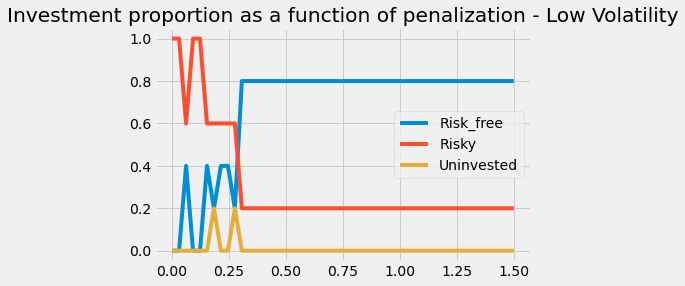

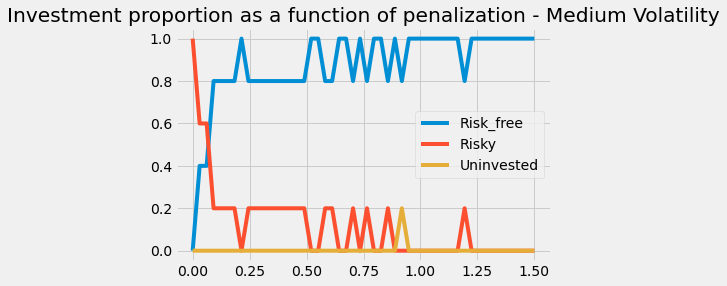

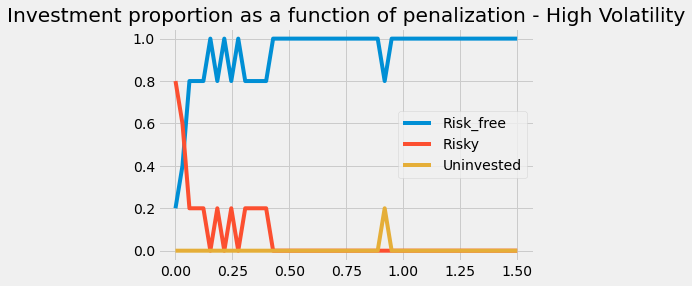

In [60]:
plt.style.use('fivethirtyeight')
plt.plot(tab_pen,p_RF_LV, label="Risk_free")
plt.plot(tab_pen,p_R_LV, label="Risky")
plt.plot(tab_pen,p_NI_LV, label="Uninvested")
plt.legend()
plt.title("Investment proportion as a function of penalization - Low Volatility")
plt.show()

plt.plot(tab_pen,p_RF_MV, label="Risk_free")
plt.plot(tab_pen,p_R_MV, label="Risky")
plt.plot(tab_pen,p_NI_MV, label="Uninvested")
plt.legend()
plt.title("Investment proportion as a function of penalization - Medium Volatility")
plt.show()

plt.plot(tab_pen,p_RF_HV, label="Risk_free")
plt.plot(tab_pen,p_R_HV, label="Risky")
plt.plot(tab_pen,p_NI_HV, label="Uninvested")
plt.legend()
plt.title("Investment proportion as a function of penalization - High Volatility")
plt.show()

## Efficient Frontier

Finally, we plot the efficient frontier using a simulation based method.

In [9]:
portfolio = Portfolio()
init_state = 2

n_portofolio = 500
n_test = 3000

esp = []
var = []
sr = []

for _ in trange(n_portofolio):
    returns=[]
    actions = npr.randint(low=0, high=portfolio.num_actions, size=portfolio.T-1)
    for __ in range(n_test):
        portfolio.reset(init_state)
        for t in range(portfolio.T-1):
            idx_action= actions[t]
            state,reward= portfolio.act(idx_action)
        returns.append(portfolio.total_reward)
    esp.append(np.mean(returns))
    var.append(np.var(returns))
    sr.append(esp[-1]/np.sqrt(var[-1]))

  0%|          | 0/500 [00:00<?, ?it/s]

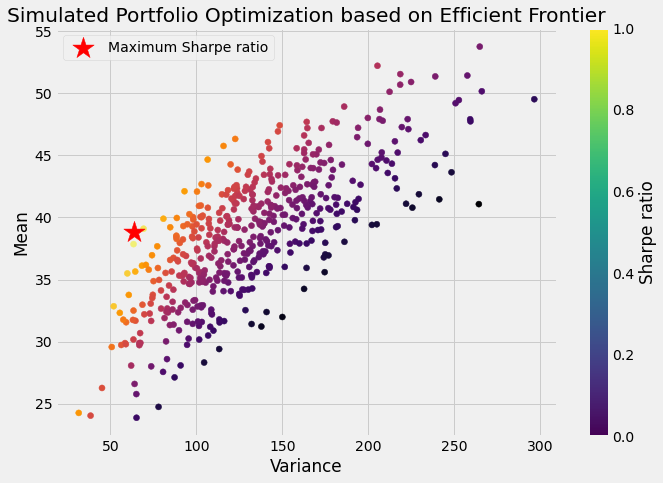

In [31]:
max_sharpe_idx = np.argmax(sr)
sdp, rp = var[max_sharpe_idx], esp[max_sharpe_idx]
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 7))
plt.scatter(var,esp,c=sr,cmap='inferno', marker='o') # ,s=10, alpha=0.3
plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
cbar=plt.colorbar()
cbar.ax.set_ylabel('Sharpe ratio')
plt.xlabel("Variance")
plt.ylabel("Mean")
plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
plt.legend()
plt.show()